In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
#export
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import pandas as pd

In [0]:
# Plus 10 data
train_url = 'https://raw.githubusercontent.com/Ghost-8D/thesis_project/master/PSSP_Playground/datasetsPlus10/trainSet0.txt'
test_url = 'https://raw.githubusercontent.com/Ghost-8D/thesis_project/master/PSSP_Playground/datasetsPlus10/testSet0.txt'

In [6]:
! mkdir pssp_model
! ls

mkdir: cannot create directory ‘pssp_model’: File exists
pssp_model  sample_data


In [7]:
path = Path('/pssp_model')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/pssp_model')

In [0]:
def get_data():
    df_train = pd.read_csv(train_url, header=None)
    df_valid = pd.read_csv(test_url, header=None)
    def get_XY_from_df(df):
        x = df.values[:, :-1]
        y = df.values[:, TOTAL_COLS-1]
        return x, y
    x_train, y_train = get_XY_from_df(df_train)
    x_valid, y_valid = get_XY_from_df(df_valid)
    x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
    return x_train.float(), y_train, x_valid.float(), y_valid

def normalize(x, m, s): return (x-m)/s

In [9]:
NEIGHBOURS = 10 # 1 amino-acid left and 1 amino-acid right added 
AMINO_ACID_LEN = 20
WINDOW = 2 * NEIGHBOURS + 1
TOTAL_AMINO_ACIDS = WINDOW * AMINO_ACID_LEN
TOTAL_COLS = TOTAL_AMINO_ACIDS + 1 # plus the secondary structure category
CATEGORIES = 3
TOTAL_COLS

421

In [10]:
x_train, y_train, x_valid, y_valid = get_data()
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  ...,  0.,  0.,  0.],
         [18., 10., 64.,  ...,  0.,  0.,  0.]]),
 torch.Size([77092, 420]),
 tensor([0, 0, 1,  ..., 1, 0, 0]),
 torch.Size([77092]),
 tensor(0),
 tensor(2))

In [0]:
assert n==y_train.shape[0]==77092
test_eq(c, WINDOW * AMINO_ACID_LEN)
test_eq(y_train.min(),0)
test_eq(y_train.max(),2)

In [12]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([77092, 420]),
 torch.Size([77092]),
 torch.Size([7289, 420]),
 torch.Size([7289]))

In [13]:
mpl.rcParams['image.cmap'] = 'cool'
img = x_train[0]
img.view(WINDOW, AMINO_ACID_LEN).type()

'torch.FloatTensor'

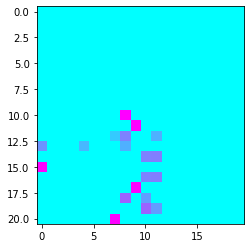

In [14]:
plt.imshow(img.view((21,20)));

In [15]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(4.7987), tensor(11.2503))

In [0]:
def normalize(x, m, s): return (x-m)/s

In [0]:
x_train = normalize(x_train, train_mean, train_std)
# NOTE: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

In [18]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(5.2017e-05), tensor(1.))

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np

In [0]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [0]:
class Lin(Module):
    def __init__(self, w, b): 
        super().__init__()
        self.w,self.b = w,b
    
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [0]:
class Relu(Module):
    def __init__(self): super().__init__()
    def forward(self, inp): return torch.clamp(inp, 0, 1e10) #return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): return out == inp #inp.g = (inp>0).float() * out.g

In [0]:
class Model():
    def __init__(self, n_in, nh, n_out):
        self.layers = nn.ModuleList([Lin(n_in, nh), Relu(), Lin(nh, n_out)])
        self.loss = nn.CrossEntropyLoss()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out), nn.ReLU()]
        self.loss = nn.CrossEntropyLoss()
        self.params = [torch.randn(n_in, nh) * math.sqrt(2.0/n_in),
                           torch.randn(nh),
                           torch.randn(nh, n_out) * math.sqrt(2.0/nh),
                           torch.randn(n_out)]
        
    def __call__(self, x):
        self.activations = []
        self.d_activations = []
        for l in self.layers: 
            out_x = l(x)
            if (isinstance(l, type(nn.ReLU()))):
                self.activations.append(x)
                self.d_activations.append(x == out_x)
            x = out_x
        return x 

    def parameters(self):
        return self.params

In [0]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [0]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [0]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [0]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)
nh,bs = 50, 78000
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [32]:
model = nn.Sequential(nn.Linear(420,50), nn.ReLU(), nn.Linear(50,3))
model.parameters()

<generator object Module.parameters at 0x7fa32262e150>

In [0]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c)) #Model(m, nh, data.c) 
    return model, optim.SGD(model.parameters(), lr=lr) #HessianFree(model.parameters(), CG_iter=100, init_damping=20, net=model)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.0, 0.0
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [36]:
loss,acc = fit(10, learn)

0 tensor(11.9970) tensor(0.3308)
1 tensor(18.8337) tensor(0.4276)
2 tensor(1.1143) tensor(0.2479)
3 tensor(1.0906) tensor(0.4232)
4 tensor(1.0811) tensor(0.4269)
5 tensor(1.0662) tensor(0.4383)
6 tensor(1.0445) tensor(0.4514)
7 tensor(1.0703) tensor(0.4267)
8 tensor(1.0523) tensor(0.4349)
9 tensor(1.1122) tensor(0.4073)


In [0]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [0]:
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [0]:
from typing import *
from functools import partial

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [0]:
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [0]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [0]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [0]:
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [0]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [0]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [0]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [0]:
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [0]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(pssp_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [0]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [0]:
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [0]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [0]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [0]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [56]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]
cbfs.append(CudaCallback)
pssp_view = view_tfm(1,21,20)
cbfs.append(partial(BatchTransformXCallback, pssp_view))
nfs = [8,16,32,32]
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=3, bias=True)
)

In [57]:
run.fit(3, learn)

train: [1.086500240783739, tensor(0.4254, device='cuda:0')]
valid: [1.074203342579572, tensor(0.4287, device='cuda:0')]
train: [1.0703059129027654, tensor(0.4260, device='cuda:0')]
valid: [1.070061359047023, tensor(0.4278, device='cuda:0')]
train: [1.0648196716261091, tensor(0.4255, device='cuda:0')]
valid: [1.0677507818930922, tensor(0.4278, device='cuda:0')]


In [0]:
toy_x_train = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
toy_y_train = np.array([0, 1, 1, 0])
toy_x_valid = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
toy_y_valid = np.array([0, 1, 1, 0])
toy_x_train, toy_y_train, toy_x_valid, toy_y_valid = torch.from_numpy(toy_x_train).float(), torch.from_numpy(toy_y_train), torch.from_numpy(toy_x_valid).float(), torch.from_numpy(toy_y_valid)
toy_train_ds,toy_valid_ds = Dataset(toy_x_train, toy_y_train),Dataset(toy_x_valid, toy_y_valid)
toy_nh, toy_bs = 120, 4
toy_c = toy_y_train.max().item()+1
loss_func = F.cross_entropy
toy_data = DataBunch(*get_dls(toy_train_ds, toy_valid_ds, toy_bs), toy_c)

In [59]:
new_y_train = []
for i in range(0, len(y_train)):
    temp = [0, 0, 0]
    temp[y_train[i].item()] = 1
    new_y_train.append(temp)
new_y_train = np.array(new_y_train)
new_y_train = torch.from_numpy(new_y_train)
new_y_train, y_train

(tensor([[1, 0, 0],
         [1, 0, 0],
         [0, 1, 0],
         ...,
         [0, 1, 0],
         [1, 0, 0],
         [1, 0, 0]]), tensor([0, 0, 1,  ..., 1, 0, 0]))

In [0]:
def get_loss(output, targets):
    expand_targets = torch.zeros_like(output)
    for i in range(0, len(expand_targets)): expand_targets[i][targets[i]] = 1
    assert output.shape[0] == 4
    # return torch.sum((output - expand_targets) * (output - expand_targets)) / (2.0 * output.shape[0])
    # temp = -np.sum(np.nan_to_num(targets) * np.log(1e-15 + output[-1]))
    temp = -torch.sum(expand_targets * torch.log(1e-8 + output))
    # temp = torch.nn.functional.cross_entropy(output[-1] + 1e-8, targets)
    # print("loss",-torch.sum(targets * torch.log(1e-8 + output[-1]), 1).mean())
    # print(temp)
    # print("cross entropy", torch.nn.functional.cross_entropy(output[-1], torch.argmax(targets, dim=1)))
    # print("acc:", calc_accuracy(output[-1], targets))
    return temp

def d_loss(output, targets):
    expand_targets = torch.zeros_like(output)
    for i in range(0, len(expand_targets)): expand_targets[i][targets[i]] = 1
    # return (output - expand_targets)
    return -(expand_targets) / (1e-8 + output)

    temp = []
    for o in output:
        temp.append(torch.zeros_like(o))            #temp.append(np.zeros_like(o))
    # temp[-1] = -targets[torch.argmax(targets, dim=1)] / (1e-8 + output[-1])
    temp[-1] = -targets / (1e-8 + output[-1])       #output[-1]
    # print(temp[-1])
    return temp

def d2_loss(output, targets):
    # return torch.ones_like(output)
    # print(output.shape, targets.shape)
    return torch.sum(torch.diag_embed(output, offset=0, dim1=-2, dim2=-1) - 
                     output.unsqueeze(-1) @ output.unsqueeze(1), 1)
    # print(output.unsqueeze(-1).shape, output.unsqueeze(1).shape)
    # print(output.shape, targets.shape)
    # print(torch.diag_embed(output, offset=0, dim1=-2, dim2=-1))
    # print((output.unsqueeze(-1) @ output.unsqueeze(1)).shape)
    # print(targets / (output ** 2))
    expand_targets = torch.zeros_like(output)
    for i in range(0, len(expand_targets)): expand_targets[i][targets[i]] = 1
    # print(expand_targets + 1e-8 / ((output) ** 2 + 1e-8))
    return (expand_targets / ((output) ** 2 + 1e-8)).t()

    return torch.diag_embed(output, offset=0, dim1=-2, dim2=-1) - output.unsqueeze(-1) @ output.unsqueeze(1)
    # print(torch.diag(output.squeeze()).shape, output.t().shape, output.shape)
    return torch.diag(output.squeeze()) - output.t() @ output
    # print(output.shape, targets.shape)
    # temp = []
    # for i in output:
    #     temp.append(torch.diag(output[o]) - output[o] @ output[o].t())
    # return temp
    return new_y_train / ((1e-5 + output) ** 2)
    # temp = []
    # for o in output:
    #     temp.append(torch.zeros_like(o))                  #temp.append(np.zeros_like(o))
    # # print(targets[torch.argmax(targets, dim=1)] / (1e-8 + output[-1]) ** 2)
    # # temp[-1] = targets[torch.argmax(targets, dim=1)] / (1e-8 + output[-1]) ** 2
    # temp[-1] = targets / ((1e-8 + output[-1]) ** 2)         #output[-1] ** 2
    # # print(temp[-1])
    # return temp

def make_flat_v1(tensor_list):
    temp = []
    for c in range(0, len(tensor_list), 2):
        temp.append(tensor_list[c].t().flatten())
    for c in range(1, len(tensor_list), 2):
        temp.append(tensor_list[c].t().flatten())
    return torch.cat(temp, dim=0)

def make_flat(tensor_list):
    temp = []
    for c in range(0, len(tensor_list)):
        temp.append(tensor_list[c].view(-1))
    return torch.cat(temp, dim=0)

def calc_accuracy(out, yb): 
    # print(out.shape, yb.shape)
    # print(out[:10])
    # print(yb[:10])
    return (torch.argmax(out, dim=1)==torch.argmax(yb, dim=1)).float().mean()

def inner_product(arr1, arr2):
    if len(arr1) != len(arr2): return None
    product = 0.0
    for i in range(0, len(arr1)):
        product += torch.matmul(arr1[i].view(-1), arr2[i].view(-1))
    return product

def J_dot(J, vec, transpose_J=False, out=None):
    """Compute the product of a Jacobian and some vector."""

    if J.ndim == 2:
        # note: the first dimension is the batch, so ndim==2 means
        # this is a vector representation
        if out is None:
            # passing out=None fails for some reason
            return torch.mul(J, vec) #np.multiply(J, vec)
        else:
            return torch.mul(J, vec, out=out) #np.multiply(J, vec, out=out)
    else:
        if transpose_J:
            J = torch.transpose(J, 2, 1) #np.transpose(J, (0, 2, 1))

        if out is None:
            # passing out=None fails for some reason
            return torch.einsum("ijk,ik->ij", J, vec) 
            #np.einsum("ijk,ik->ij", J, vec)

        if out is vec:
            tmp_vec = vec.copy()
        else:
            tmp_vec = vec

        return torch.einsum("ijk,ik->ij", J, tmp_vec, out=out) 
        #np.einsum("ijk,ik->ij", J, tmp_vec, out=out)

In [0]:
from torch.optim import Optimizer

class HessianFree(Optimizer):
    """Implements Hessian Free Optimisation algorithm.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        CG_iter (int): maximum number of CG iterations to run per epoch
        init_damping (float): the initial value of the Tikhonov damping
        net (nn.Module): the network that uses this optimizer
    """

    def __init__(self, params, CG_iter=250, init_damping=1, net=None):
        if not 0.0 <= CG_iter:
            raise ValueError("Invalid number of CG iterations: {}".format(cg_iter))
        if not 0.0 <= init_damping:
            raise ValueError("Invalid Tikhonov damping value: {}".format(init_damping))
        if net == None:
            raise ValueError("Invalid net value: {}".format(net))
        
        defaults = dict(CG_iter=CG_iter, damping=init_damping, net=net)
        super(HessianFree, self).__init__(params, defaults)
        
        self.CG_iter = CG_iter
        self.damping = init_damping
        self.net = net
        self.init_delta = None
        self.params = None

    # def grad_params(self):
    #     return [p for pg in self.param_groups
    #         for p in pg if p.grad is not None]

    # def zero_grad(self):
    #     for p in self.grad_params():
    #         p.grad.detach_()
    #         p.grad.zero_()

    def step(self, closure=None):
        err = closure()  # note: don't reuse previous error (diff batch)

        # compute gradient
        params = []
        grads = []
        for group in self.param_groups:
            for p in group['params']:
                params.append(p.data)
                if p.grad is None:
                    continue
                grads.append(p.grad.data) 
        self.params = params
        # print(grads)
        # grad = make_flat(grads) #grad = self.net.backward()
        
        # run CG
        if self.init_delta is None:
            self.init_delta = [torch.zeros_like(p, requires_grad=False) 
                               for p in self.params]
        deltas = self.conjugate_gradient(self.init_delta, grads, iters=self.CG_iter)

        self.init_delta = deltas[-1][1]  # note: don't backtrack this

        # CG backtracking
        new_err = np.inf
        for j in range(len(deltas) - 1, -1, -1):
            # new_params = []
            # for group in self.param_groups:
            #     for c, p in enumerate(group['params']):
            #         new_params.append(p + deltas[j][1][c])
            new_params = [self.params[p] + deltas[j][1][p] for p in range(0, len(self.params))]
            prev_err = closure(new_params)
            # prev_err = closure(W + deltas[j][1])
            # print("prev", prev_err, "new", new_err)
            if prev_err > new_err:
                break
            delta = deltas[j][1]
            new_err = prev_err
        else:
            j -= 1
        
        # update damping parameter (compare improvement predicted by
        # quadratic model to the actual improvement in the error)
        quad = (0.5 * inner_product(self.calc_G(delta, damping=self.damping), 
                                    delta) + inner_product(grads, delta))
        # print(quad.item())
        improvement_ratio = ((new_err - err) / quad) if quad != 0 else 1
        if improvement_ratio < 0.25:
            self.damping *= 1.5
        elif improvement_ratio > 0.75:
            self.damping *= 0.66
        # print(improvement_ratio.item(), quad.item())
        # line search to find learning rate
        l_rate = 1.0
        min_improv = min(1e-2 * inner_product(grads, delta), 0)
        
        for _ in range(60):
            # check if the improvement is greater than the minimum
            # improvement we would expect based on the starting gradient
            if new_err <= err + l_rate * min_improv:
                break
            l_rate *= 0.8
            new_params = [self.params[p] + (l_rate * delta[p]) for p in range(0, len(self.params))]
            # new_params = []
            # for group in self.param_groups:
            #     for c, p in enumerate(group['params']):
            #         new_params.append(p + l_rate * delta[c])
            new_err = closure(new_params)
            # print("prev_err", err, "new_err", new_err)
            # new_err = closure(W + l_rate * delta)
        else:
            # no good update, so skip this iteration
            l_rate = 0.0
            new_err = err
        
        with torch.no_grad():
            for group in self.param_groups:
                for c, p in enumerate(group['params']):
                    p += l_rate * delta[c]
                    if p.grad is not None:
                        p.grad.detach_()
                        p.grad.zero_()
        # print(self.damping)
        # assert False
        return [l_rate * delta[c] for c in range(0, len(delta))]

    def conjugate_gradient(self, init_delta, grad, iters=250):
        """Find minimum of quadratic approximation using conjugate gradient
        algorithm."""

        store_iter = 5
        store_mult = 1.3
        deltas = []
        vals = torch.zeros(iters) 
        base_grad = [g.mul(-1.0) for g in grad] # note negative, some CG algorithms are flipped
        delta = [d.mul(0.95) for d in init_delta]
        G_dir = [torch.zeros_like(g, requires_grad=False) for g in grad]
        
        residual = base_grad.copy()
        self.calc_G(delta, damping=self.damping, out=G_dir)
        for r in range(0, len(residual)): residual[r].sub_(G_dir[r])
        res_norm = inner_product(residual, residual)
        direction = residual.copy()
        # print(direction)
        
        for i in range(iters):
            # calculate step size
            self.calc_G(direction, damping=self.damping, out=G_dir)
            
            step = res_norm / inner_product(direction, G_dir)
            if ((step + 1) == step or (step != step)):
                print("Non-finite step value (%f)" % step)
                break

            # update weight delta
            for d in range(0, len(delta)): delta[d] += step * direction[d]
            
            # update residual
            for r in range(0, len(residual)): residual[r].sub_(step * G_dir[r])
            new_res_norm = inner_product(residual, residual)

            if new_res_norm < 1e-20:
                # early termination (mainly to prevent numerical errors);
                # the main termination condition is below.
                break

            # update direction
            beta = new_res_norm / res_norm
            for d in range(0, len(direction)): 
                direction[d] = beta * direction[d] + residual[d]
            # direction *= beta
            # direction += residual

            res_norm = new_res_norm

            # store deltas for backtracking
            if i == store_iter:
                deltas += [(i, delta.copy())]
                store_iter = int(store_iter * store_mult)

            # martens termination conditions
            temp = [residual[r] + base_grad[r] for r in range(0, len(residual))]
            vals[i] = -0.5 * inner_product(temp, delta)
            
            gap = max(int(0.1 * i), 10)

            if (i > gap and vals[i - gap] < 0 
                    and (vals[i] - vals[i - gap]) / vals[i] < 5e-6 * gap):
                break

        deltas += [(i, delta.copy())]
        return deltas

    def calc_G(self, v, damping=0, out=None):
        """Compute Gauss-Newton matrix-vector product."""

        if out is None:
            Gv = [torch.zeros_like(val, requires_grad=False) for val in v]
        else:
            Gv = out
            for val in Gv: val.fill_(0.0)

        # R forward pass
        R_activations = [torch.zeros_like(a, requires_grad=False) for a in self.net.activations] 
        for i in range(1, len(R_activations)):
            R_activations[i].add_(self.net.activations[(i-1)] @ v[(i-1)*2].t() + v[(i-1)*2 + 1].unsqueeze(0))
            R_activations[i].add_(R_activations[(i-1)] @ self.params[(i-1)*2].t())
            R_activations[i].mul_(self.net.d_activations[i])
            # R_activations[i] = J_dot(self.net.d_activations[i], R_activations[i])
        
        # backward pass
        R_error = R_activations
        for i in range(len(R_error)-1, 0, -1):
            if (i == len(R_error)-1): 
                R_error[i] *= self.net.d2_loss_v
            else:
                R_error[i].fill_(0.0)

            # RDs[i] = RDa[i] * self.net.d_activations[i].t() 
            # RDW[i] = RDs[i] @ self.net.activations[(i-1)].t()
            # RDb[i] = RDs[i]
            # RDa[i-1] = params[i*2].t() @ RDs[i]

            R_error[i] *= self.net.d_activations[i]
            Gv[(i-1)*2] = R_error[i].t() @ self.net.activations[i-1]
            Gv[(i-1)*2+1] = torch.sum(R_error[i], 0)
            R_error[i-1] += R_error[i] @ self.params[(i-1)*2]
        # print(R_activations[0].shape[0])
        for val in Gv: val /= (R_activations[0].shape[0])

        for i in range(0, len(Gv)): Gv[i] += damping * v[i]  # Tikhonov damping
        return Gv

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers, shapes=None):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        self.d2_loss_v = None
        self.shapes = shapes
        self.compute_offsets()
        
    def __call__(self, x):
        self.activations = []
        self.d_activations = []
        self.activations.append(x)
        self.d_activations.append(x == x)
        for i,l in enumerate(self.layers):
            out_x = l(x)
            if (isinstance(l, type(nn.ReLU()))):
                self.activations.append(x)
                self.d_activations.append(x == out_x)
            x = out_x
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std())
        return x
    
    def __iter__(self): return iter(self.layers)

    def compute_offsets(self):
        """Precompute offsets for layers in the overall parameter vector."""
        self.offsets = {}
        offset = 0
        for i in range(0, len(self.shapes)):
            n_params = (self.shapes[i][0] + 1) * self.shapes[i][1]
            self.offsets[i] = (offset, 
                               offset + n_params - self.shapes[i][1], 
                               offset + n_params)
            offset += n_params
        return offset

    def get_weights(self, params, conn):
        """Get weight matrix for a connection from overall parameter vector."""

        if conn not in self.offsets:
            return None

        offset, W_end, b_end = self.offsets[conn]
        W = params[offset:W_end]
        b = params[W_end:b_end]
        return W.reshape((self.shape[conn[0]], self.shape[conn[1]])), b

In [0]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    shapes = [(m, nh), (nh, data.c)]
    model = SequentialModel(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c), nn.ReLU(), shapes=shapes) 
    return model, HessianFree(model.parameters(), CG_iter=500, init_damping=20, net=model) #optim.SGD(model.parameters(), lr=lr) 

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [0]:
toy_learn = Learner(*get_model(toy_data), loss_func, toy_data)

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            y_hat = learn.model(xb)
            loss = learn.loss_func(y_hat, yb)
            learn.model.d2_loss_v = d2_loss(y_hat, yb)
            loss.backward()
            # print(get_loss(y_hat, yb))
            def closure(new_params=None):
                if new_params:
                    y_hat_new = xb.clone().detach()
                    for i in range(0, len(new_params), 2):
                        y_hat_new = y_hat_new @ new_params[i].t() + new_params[i+1]
                        y_hat_new.clamp_min_(0.)
                    loss = learn.loss_func(y_hat_new, yb)
                    # loss = get_loss(y_hat_new, yb)
                    # print(loss)
                else:
                    loss = learn.loss_func(learn.model(xb), yb)
                    # loss = get_loss(learn.model(xb), yb)
                return loss
            update = learn.opt.step(closure)
            learn.opt.zero_grad()
            # print(update)
            # with torch.no_grad():
            #     for c, p in enumerate(learn.model.parameters()):
            #         p += update[c]
            # with torch.no_grad():
            #     for c, p in enumerate(learn.model.parameters()):
            #         print(p)
        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.0, 0.0
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
        torch.cuda.empty_cache()
    return tot_loss/nv, tot_acc/nv

In [75]:
def make_flat_v2(tensor_list):
    temp = []
    for c in range(0, len(tensor_list)):
        temp.append(tensor_list[c].view(-1))
    return torch.cat(temp, dim=0)

def inner_product(tens1, tens2):
    if len(tens1) != len(tens2): return None
    product = 0
    for i in range(0, len(tens1)):
        product += torch.matmul(tens1[i].view(-1), tens2[i].view(-1))
    return product

start = [0, 8, 12, 20, 22]
end = [8, 12, 20, 22, 24]
def get(array, i, shape):
    s = start[i] 
    e = end[i]
    return array[s:e].view(shape)

m = torch.tensor(np.arange(22))
print(get(m, 0, (2,4)))
x = torch.tensor([[1,5], [2,6], [3, 7], [4, 8]])
y = torch.tensor([17, 18, 19, 20])
z = torch.tensor([[9, 11, 13,15], [10, 12, 14, 16]])
w = torch.tensor([21, 22])
ar = [x, y, z, w]
shapes = []
for s in ar: 
    print(s.view(-1))
    shapes.append(s.shape)
    # print(s.t().shape)

f = make_flat_v2(ar)
# for i,d in enumerate(f):
#     d.reshape(shapes[i])
print(f)
print(make_flat(x), make_flat(z))
# quad = (0.5 * torch.matmul(make_flat(temp_G), flat_delta) + torch.matmul(grad, flat_delta))
torch.matmul(make_flat(x), make_flat(z.t())), inner_product([x], [z])
# (make_flat(x) * make_flat(z).t()).sum()

tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])
tensor([1, 5, 2, 6, 3, 7, 4, 8])
tensor([17, 18, 19, 20])
tensor([ 9, 11, 13, 15, 10, 12, 14, 16])
tensor([21, 22])
tensor([ 1,  5,  2,  6,  3,  7,  4,  8, 17, 18, 19, 20,  9, 11, 13, 15, 10, 12,
        14, 16, 21, 22])
tensor([1, 5, 2, 6, 3, 7, 4, 8]) tensor([ 9, 11, 13, 15, 10, 12, 14, 16])


(tensor(478), tensor(478))

In [76]:
# torch.diag_embed(output, offset=0, dim1=-2, dim2=-1) - output.unsqueeze(-1) @ output.unsqueeze(1)
y = torch.tensor([[0], [2], [2]])
y_new = [[0, 0, 0, 0] for temp in y]
for i in range(0, len(y_new)): y_new[i][y[i]] = 1
y_new = torch.tensor(y_new)
x = torch.tensor([[1., 2., 3., 4.], [2, 3, 4, 5], [3, 4, 5, 6]])
bd2 = torch.diag_embed(x, offset=0, dim1=-2, dim2=-1) - x.unsqueeze(-1) @ x.unsqueeze(1)
d1 = torch.diag(x[0]) - x[0].unsqueeze(-1).t() @ x[0].unsqueeze(1)
print(y_new)
print(x.shape, y.shape)
print(y_new / (x ** 2))
y_new = torch.zeros_like(x)
for i in range(0, len(y_new)): y_new[i][y[i]] = 1
print(y_new)
print(y_new / (x ** 2))

tensor([[1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0]])
torch.Size([3, 4]) torch.Size([3, 1])
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0625, 0.0000],
        [0.0000, 0.0000, 0.0400, 0.0000]])
tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0625, 0.0000],
        [0.0000, 0.0000, 0.0400, 0.0000]])


In [69]:
fit(50, toy_learn)

0 tensor(0.6986) tensor(0.5000)
1 tensor(0.6885) tensor(0.5000)
2 tensor(0.6801) tensor(0.5000)
3 tensor(0.6724) tensor(0.7500)
4 tensor(0.6622) tensor(1.)
5 tensor(0.6469) tensor(1.)
6 tensor(0.6238) tensor(1.)
7 tensor(0.5905) tensor(1.)
8 tensor(0.5380) tensor(1.)
9 tensor(0.4791) tensor(1.)
10 tensor(0.4575) tensor(0.7500)
11 tensor(0.4355) tensor(1.)
12 tensor(0.4205) tensor(0.7500)
13 tensor(0.4200) tensor(0.7500)
14 tensor(0.3951) tensor(1.)
15 tensor(0.3908) tensor(1.)
16 tensor(0.3905) tensor(1.)
17 tensor(0.3892) tensor(1.)
18 tensor(0.3892) tensor(1.)
19 tensor(0.3811) tensor(1.)
20 tensor(0.3715) tensor(1.)
21 tensor(0.3650) tensor(1.)
22 tensor(0.3599) tensor(1.)
23 tensor(0.3595) tensor(1.)
24 tensor(0.3595) tensor(1.)
25 tensor(0.3575) tensor(1.)
26 tensor(0.3511) tensor(1.)
27 tensor(0.3405) tensor(1.)
28 tensor(0.3097) tensor(1.)
29 tensor(0.3077) tensor(1.)
30 tensor(0.3077) tensor(1.)
31 tensor(0.3077) tensor(1.)
32 tensor(0.3077) tensor(1.)
33 tensor(0.3054) tensor(

(tensor(0.2403), tensor(1.))

In [0]:
fit(5, learn)

0 tensor(1.2801) tensor(0.4077)
1 tensor(1.0982) tensor(0.3268)


In [71]:
ar1 = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
ar2 = np.array([[1,0], [0,1], [0,1], [1,0]])
pr = np.array([[[0.2,0.7], [0.2,0.1], [0.8,0.9], [0.8,0.5]],
               [[0.3,0.7], [0.2,0.1], [0.8,0.9], [0.8,0.5]],
               [[0.2,0.7], [0.2,0.1], [0.8,0.9], [0.8,0.5]]])
losses = np.sum(np.nan_to_num(pr - ar2) ** 2, axis=tuple(range(1, pr.ndim))) / 2
losses = -np.sum(np.nan_to_num(ar2) * np.log(pr), axis=tuple(range(1, pr.ndim)))
print(losses)
check_loss = np.sum([np.true_divide(np.sum(l), 1) for l in losses if l is not None])
print(check_loss)
new_pr = (torch.tensor([t.flatten() for t in pr]))
print(new_pr.shape)
print(torch.diag(torch.tensor(pr[0].flatten()) * (1 - pr[0].flatten())))
assert (new_pr.unsqueeze(-1) @ new_pr.unsqueeze(1)).shape == torch.diag_embed(new_pr, offset=0, dim1=-2, dim2=-1).shape
testing = torch.sum(torch.diag_embed(new_pr, offset=0, dim1=-2, dim2=-1) - new_pr.unsqueeze(-1) @ new_pr.unsqueeze(1), 0)
print(testing.clamp_min(0.0))

[4.240527 3.835062 4.240527]
12.31611610909238
torch.Size([3, 8])
tensor([[0.1600, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1600, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0900, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1600, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0900, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1600, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500]],
       dtype=torch.float64)
tensor([[0.5300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4800, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2700, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 